# Figures for fits to UHECR data

Here, we use the output from the `fits_to_data` notebook to plot the figures shown in the paper. Here, we show the result for the SBG catalogue, but the other two cases can be created by switching the catalogue in the `fits_to_data` notebook.
<br>
<br>
*This code was used to produce Figures 9, 10, 11 and 12 in Capel & Mortlock (2019)*.

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import h5py
plt.style.use('minimalist')

from fancy import Data, Results
from fancy.plotting import AllSkyMap
from fancy.plotting.colours import lightblue, midblue, midblue_contour, darkblue, lightpurple, darkpurple, purple, grey
from fancy.plotting import Corner
from fancy.interfaces.stan import Direction

In [11]:
# Define data files
source_file = '../../../data/sourcedata.h5'
uhecr_file = '../../../data/UHECRdata.h5'

source_type = "SBG_23"
source_label = "Swift-BAT" if source_type == "swift_BAT_213" else source_type.split("_")[0]
detector_type = "TA2015"

# Define output files
arrival_output_file = '../output/arrival_fit_data_{0}_{1}.h5'.format(source_type, detector_type)
joint_output_file = '../output/joint_fit_data_{0}_{1}.h5'.format(source_type, detector_type)

# files containing data without randomization
arrival_output_file_norand = '../../../fit_to_data/output/arrival_fit_{0}_{1}.h5'.format(source_type, detector_type)
joint_output_file_norand = '../../../fit_to_data/output/joint_fit_{0}_{1}.h5'.format(source_type, detector_type)

In [12]:
'''set detector and detector properties'''
if detector_type == "TA2015":
    from fancy.detector.TA2015 import detector_properties, Eth
elif detector_type == "auger2014":
    from fancy.detector.auger2014 import detector_properties, Eth
elif detector_type == "auger2010":
    from fancy.detector.auger2010 import detector_properties, Eth
else:
    raise Exception("Undefined detector type!")

## Info used in a few plots

In [13]:
# Read in result data
with h5py.File(joint_output_file, 'r') as f:
    uhecr = f['uhecr']
    arrival_direction = Direction(uhecr['unit_vector'][()])
    energy = uhecr['energy'][()]
    
    source = f['source']
    source_direction = Direction(source['unit_vector'][()])  

# get original uhecr directions
data = Data()
data.add_source(source_file, source_type)
data.add_uhecr(uhecr_file, detector_type)
data.add_detector(detector_properties)

uhecr_directions_rand = Direction(data.uhecr.unit_vector)
energy_rand = data.uhecr.energy

In [18]:
# UHECR energy
# max. of energy bin, set s.t. values in 
# max(np.digitize(energy, energy_bins) - 1) < len(uhecr_color)
Emax = np.ceil(np.max(energy) / 10.) * 10.  

# UHECRs
uhecr_color = [lightblue, midblue, darkblue]
uhecr_cmap = mpl.colors.ListedColormap(uhecr_color)
energy_bins = np.logspace(np.log(Eth), np.log(Emax), 4, base = np.e)
uhecr_norm = mpl.colors.BoundaryNorm(energy_bins, uhecr_cmap.N)

# UHECR energy
# max. of energy bin, set s.t. values in 
# max(np.digitize(energy, energy_bins) - 1) < len(uhecr_color)
Emax_rand = np.ceil(np.max(energy_rand) / 10.) * 10.  

uhecr_color_rand = [lightpurple, purple, darkpurple]
uhecr_cmap_rand = mpl.colors.ListedColormap(uhecr_color_rand)
energy_bins_rand = np.logspace(np.log(Eth), np.log(Emax_rand), 4, base = np.e)
uhecr_norm_rand = mpl.colors.BoundaryNorm(energy_bins_rand, uhecr_cmap_rand.N)

# Legend
legend_elements = [mpl.lines.Line2D([0], [0], marker = 'o', color = 'w', 
                                    label = source_label, markersize = 10, 
                                    markerfacecolor = 'k'),
                   mpl.lines.Line2D([0], [0], marker = 'o', color='w', 
                                    label = 'UHECRs', markersize = 15, 
                                    markerfacecolor = midblue, alpha = 0.8),
                    mpl.lines.Line2D([0], [0], marker = 'o', color='w', 
                                    label = 'Randomized UHECRs', markersize = 15, 
                                    markerfacecolor = purple, alpha = 0.8)]

## Figure 9
Source catalogues and Auger UHECRs

In [19]:
from astropy.coordinates import SkyCoord
import astropy.units as u

In [20]:
# Exposure
num_points = 10000
rightascensions = np.linspace(-180, 180, num_points)
limiting_dec = data.detector.limiting_dec.deg
boundary_decs = np.tile(limiting_dec, num_points)
c = SkyCoord(ra = rightascensions * u.degree,
             dec = boundary_decs * u.degree, frame = 'icrs')
exp_lon = c.galactic.l.deg
exp_lat = c.galactic.b.deg

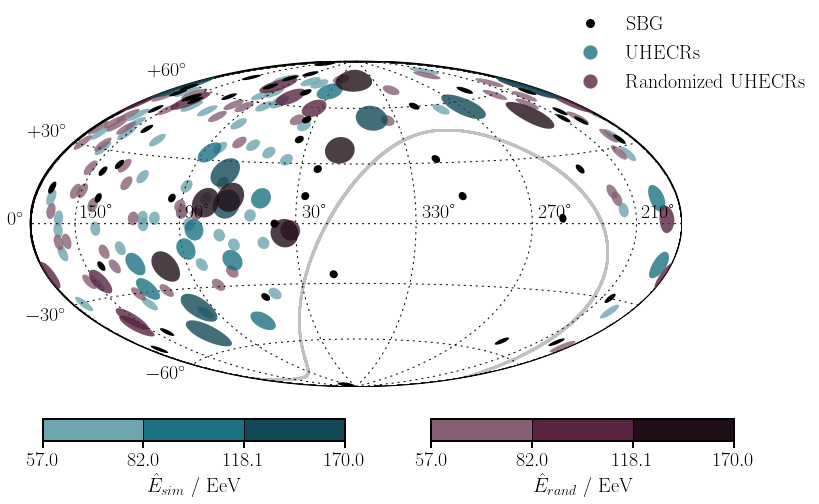

In [21]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0, lat_0 = 0);

# Sources
for lon, lat in np.nditer([source_direction.lons, source_direction.lats]):
    skymap.tissot(lon, lat, 2.0, 30, facecolor = 'k', alpha = 1.0, zorder = 5)

for lon, lat in np.nditer([source_direction.d.ra.deg, source_direction.d.dec.deg]):
    skymap.tissot(lon, lat, 2.0, 30, facecolor = 'k', alpha = 1.0, zorder = 5)
    
# UHECRs
for lon, lat, E in np.nditer([arrival_direction.lons, arrival_direction.lats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(lon, lat, 3.0 + (i*2), 30, 
                  facecolor = uhecr_cmap.colors[i], alpha = 0.8, zorder = i+2)

# Randomized UHECRs
for lon, lat, E in np.nditer([uhecr_directions_rand.lons, uhecr_directions_rand.lats, energy_rand]):
    i = np.digitize(E, energy_bins_rand) - 1
    skymap.tissot(lon, lat, 3.0 + (i*2), 30, 
                  facecolor = uhecr_cmap_rand.colors[i], alpha = 0.8, zorder = i+2)
    
    
# Exposure
# Uses scatter as bug with AllSkyMap.pcolormesh and contour that I still need to fix...
skymap.scatter(exp_lon, exp_lat, latlon = True, s = 2,
               color = grey, alpha = 1)
        
# Annotation
skymap.draw_border()
skymap.draw_standard_labels(minimal = True, fontsize = 20)
ax.legend(handles = legend_elements, bbox_to_anchor = (0.8, 0.85), fontsize = 20)

# Colorbar
cb_ax = plt.axes([0.15, 0., .35, .05], frameon = True)
bar = mpl.colorbar.ColorbarBase(cb_ax, norm = uhecr_norm, cmap = uhecr_cmap,
                                orientation = 'horizontal', drawedges = True, 
                                alpha = 1)
bar.set_label('$\hat{E}_{{sim}}$ / EeV', color = 'k', fontsize = 20)
bar.ax.tick_params(labelsize = 20) 

cb_ax_rand = plt.axes([0.6, 0, .35, .05], frameon = True)
bar_rand = mpl.colorbar.ColorbarBase(cb_ax_rand, norm = uhecr_norm_rand, cmap = uhecr_cmap_rand,
                                orientation = 'horizontal', drawedges = True, 
                                alpha = 1)
bar_rand.set_label('$\hat{E}_{{rand}}$ / EeV', color = 'k', fontsize = 20)
bar_rand.ax.tick_params(labelsize = 20) 

## Figure 10
Comparison between arrival direction and joint model.

In [22]:
# Larger fontsize
plt.rcParams['font.size'] = 22
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22

In [23]:
# Get f samples for both models and true f value.
f_a = Results(arrival_output_file).get_chain(['f'])['f']
f_j = Results(joint_output_file).get_chain(['f'])['f']

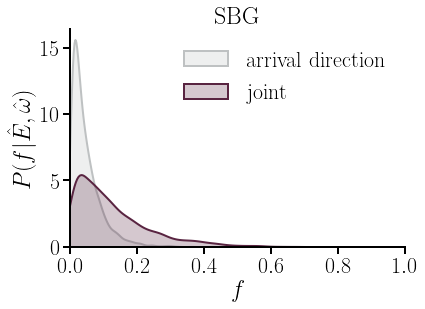

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

sns.distplot(f_a, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 0}, 
             color = grey, label = 'arrival direction')
sns.distplot(f_j, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 1}, 
             color = purple, label = 'joint')

ax.set_xlim(0, 1)
# ax.set_ylim(0, 3)
ax.set_title(source_label, fontsize = 24)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f | \hat{E}, \hat{\omega})$')
ax.legend(fontsize = 22);

## Figure 11
The association probabilities of source-UHECR pairs from the fit of the joint model. See Appendix B for how these are calculated. 

In [25]:
# Log probability
results = Results(joint_output_file)
keys = ['lp']
chain = results.get_chain(keys);
logprob = chain['lp'].transpose(1, 2, 0)
N = np.shape(logprob)[0]

# Account for background component
Ns = np.shape(logprob)[1] - 1

In [26]:
# Calculate association probabilities for each source-UHECR combo
uhecr_p = []
for lp in logprob:
    lps = []
    for src in range(Ns + 1):
        lps.append(np.mean(np.exp(lp[src])))

    norm = sum(lps)
    ps = []
    for src in range(Ns+1):
        ps.append(lps[src] / norm)
    uhecr_p.append(ps)

# Normalise line weights
pmax = max(max(uhecr_p))

In [27]:
# Find names of dominant sources
threshold_probability = 0.1

dominant = []
for p in uhecr_p:
    for i in range(data.source.N):
        if p[i] > threshold_probability:
            dominant.append(i)

seen = set()
inds = []
for d in dominant:
    if d not in seen:
        inds.append(d)
        seen.add(d)
print([data.source.name[i] for i in inds])

[b'M82']


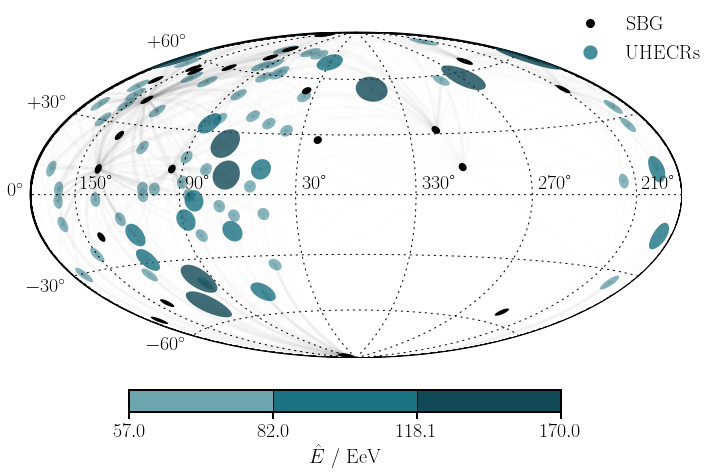

In [29]:
# Figure
fig, ax = plt.subplots()
fig.set_size_inches((12, 6))
skymap = AllSkyMap(projection = 'hammer', lon_0 = 0., lat_0 = 0.);

# Sources
for lon, lat in np.nditer([source_direction.lons, source_direction.lats]):
    skymap.tissot(lon, lat, 2.0, 30, facecolor = 'k', alpha = 1.0, zorder = 5)
    
# UHECRs
for lon, lat, E in np.nditer([arrival_direction.lons, arrival_direction.lats, energy]):
    i = np.digitize(E, energy_bins) - 1
    skymap.tissot(lon, lat, 3.0 + (i*2), 30, 
                  facecolor = uhecr_cmap.colors[i], alpha = 0.8, zorder = i+2)
    
# Association
for i, p in enumerate(uhecr_p):
    for j, psrc in enumerate(p[0:Ns]):
        if psrc > 0.001:
            skymap.geodesic(arrival_direction.lons[i], arrival_direction.lats[i], 
                            source_direction.lons[j], source_direction.lats[j], 
                            color = 'k', lw = 3, alpha = psrc/pmax, zorder = 10)

# Annotation
skymap.draw_border()
skymap.draw_standard_labels(minimal = True, fontsize = 20)
ax.legend(handles = legend_elements[:-1], bbox_to_anchor = (0.8, 0.85), fontsize = 20)

# Colorbar
cb_ax = plt.axes([0.25, 0, .5, .05], frameon = False)
bar = mpl.colorbar.ColorbarBase(cb_ax, norm = uhecr_norm, cmap = uhecr_cmap,
                                orientation = 'horizontal', drawedges = True, 
                                alpha = 1)
bar.set_label('$\hat{E}$ / EeV', color = 'k', fontsize = 20)
bar.ax.tick_params(labelsize = 20)

## Comparisons with Unrandomized UHECRs

Compare this result with unrandomized right ascensions of UHECR.

In [30]:
f_a_norand = Results(arrival_output_file_norand).get_chain(['f'])['f']
f_j_norand = Results(joint_output_file_norand).get_chain(['f'])['f']

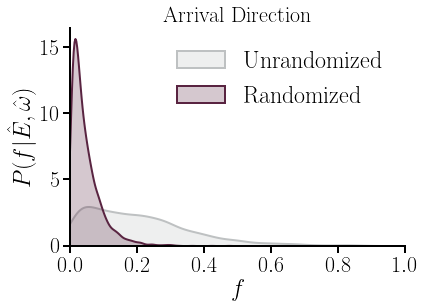

In [36]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

sns.distplot(f_a_norand, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 0}, 
             color = grey, label = 'Unrandomized')
sns.distplot(f_a, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 1}, 
             color = purple, label = 'Randomized')

ax.set_xlim(0, 1)
# ax.set_ylim(0, 10)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f | \hat{E}, \hat{\omega})$')
ax.legend(fontsize=24)

ax.set_title("Arrival Direction", fontsize=22);

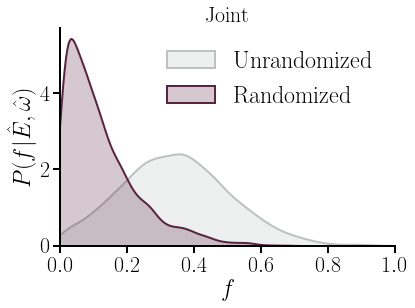

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

sns.distplot(f_j_norand, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 0}, 
             color = grey, label = 'Unrandomized')
sns.distplot(f_j, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 1}, 
             color = purple, label = 'Randomized')

ax.set_xlim(0, 1)
# ax.set_ylim(0, 10)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f | \hat{E}, \hat{\omega})$')
ax.legend(fontsize=24)

ax.set_title("Joint", fontsize=22);